# CIFAR10 Classification with EfficientNetV2B1

## Table of Contents

- [Introduction](#introduction)
- [Loading the Data](#data-loading)
- [Label Engineering](#label-engineering)
- [Defining a Model](#model-definition)
- [Training the Classifier](#classifier-training)
- [Fine-Tuning the Model](#fine-tuning)
- [Manual Error Analysis](#error-analysis)
- [Conclusion](#conclusion)

<a id="introduction"></a>
## Introduction

CIFAR10 is one of the benchmarks datasets for computer vision models. It consists of 60,000 32x32 color images divided into a training set (50,000 images) and testing set (10,000 images).
All the images are labeled into 10 classes, thus there are 6,000 images for each class:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

The dataset can be downloaded from the official website: https://www.cs.toronto.edu/~kriz/cifar.html or from `keras.datasets` API.

We will try to classify CIFAR10 with a light-weight EfficientNet neural network using multi-task learning and label smoothening.

<a id='data-loading'><a>
## Loading the Data

Let's start with loading the dataset and visualizing some images.

In [1]:
# Useful imports.
import numpy as np

from keras.datasets import cifar10
import tensorflow.keras as keras
import tensorflow as tf

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

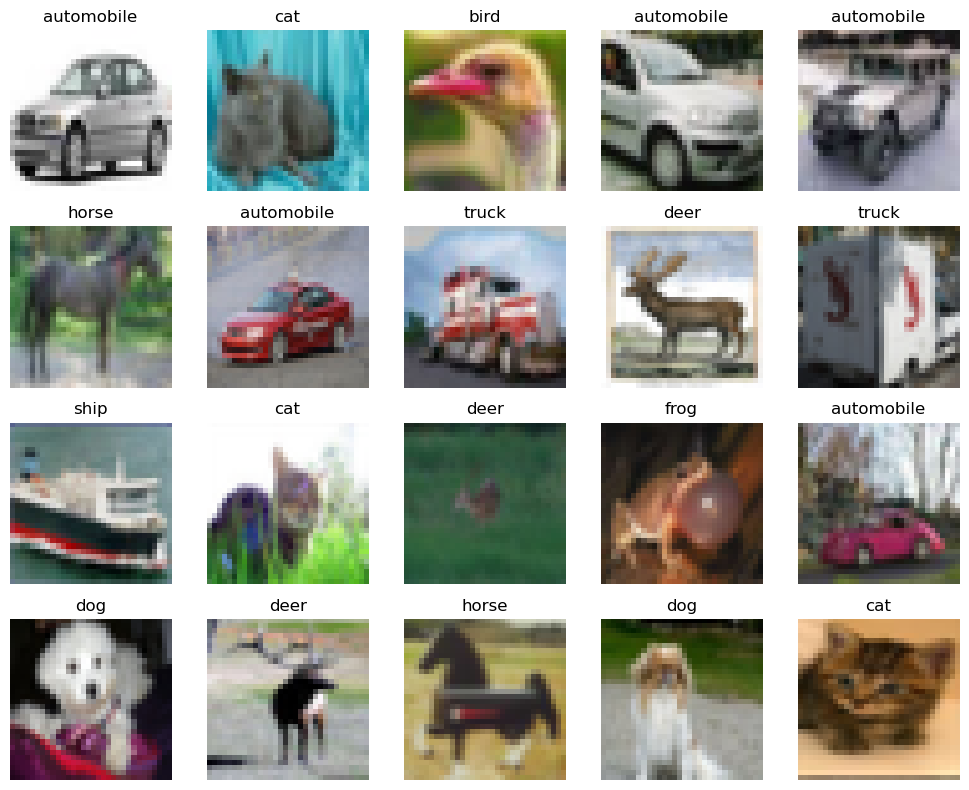

In [3]:
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Generate 20 random indices for selecting images.
random_indices = np.random.randint(0, len(x_train), size=20)

# Visualize the random images.
plt.figure(figsize=(10, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(class_labels[y_train[idx][0]])
    plt.axis('off')

plt.tight_layout()
plt.show()

<a id='label-engineering'></a>
## Label Engineering

We will leverage multitask learning and label smoothing for our modeling process. Specifically, our model will have two branches - one for predicting the class label and another for predicting the presence of an animal in the image.

To enhance the model's robustness, we will employ label smoothing by transforming with a factor of 0.1. This will turn each label into a 10-dimensional vector. In this vector, the true class will have a value of 0.9, while the remaining classes will each have a value of 0.01.

In [4]:
# Mapping of CIFAR10 classes to animals and non-animals.
animals_mapping = {
    0: 0, 1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0
}

In [5]:
def get_animals_arr(y_arr):
    animals_arr = np.zeros((y_arr.shape[0], 1))
    for i in range(y_arr.shape[0]):
        label = int(y_arr[i])
        animals_arr[i] = animals_mapping[label]
    return animals_arr

In [6]:
y_train_animals = get_animals_arr(y_train) # Get labels for animals and non-animals.
y_test_animals = get_animals_arr(y_test)

In [7]:
y_train_oh = tf.squeeze(tf.one_hot(y_train, 10)) # One-hot encode the labels.
y_test_oh = tf.squeeze(tf.one_hot(y_test, 10))

Metal device set to: Apple M2 Pro


In [8]:
# A function to smooth the labels
def smooth_labels(labels, factor=0.1):
    labels = labels * (1 - factor)
    labels = labels + (factor / labels.shape[1])
    return labels

In [9]:
y_train_smoothed = smooth_labels(y_train_oh)
y_test_smoothed = smooth_labels(y_test_oh)

<a id='model-definition'></a>
## Defining a Model

Let's define our model using a pre-trained EfficientNetV2B1 as a base model.

In [10]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), 
     keras.layers.RandomRotation(0.1),
     keras.layers.RandomZoom(0.1)]
)

base_model = keras.applications.EfficientNetV2B1(include_top=False, weights='imagenet', input_shape=(240,240,3), 
                                                 classes=10)

base_model.trainable = False 

inputs = keras.Input(shape=(32, 32, 3), name='input')
x = keras.layers.Lambda(lambda image: tf.image.resize(image, (240,240)))(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

probs = tf.keras.layers.Dense(10, activation=('linear'), name='probs')(x)
animals = tf.keras.layers.Dense(1, activation=('linear'), name='animals')(x)

model = tf.keras.Model(inputs=inputs, outputs=[probs, animals])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 240, 240, 3)  0           ['input[0][0]']                  
                                                                                                  
 sequential (Sequential)        (None, 240, 240, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 efficientnetv2-b1 (Functional)  (None, 8, 8, 1280)  6931124     ['sequential[0][0]']             
                                                                                              

Compile the model with two loss functions for two outputs of the model.

In [11]:
model.compile(optimizer=keras.optimizers.Adam(), loss=[keras.losses.CategoricalCrossentropy(from_logits=True), 
              keras.losses.BinaryCrossentropy(from_logits=True)], loss_weights=[1,0.7], 
              metrics={'probs': 'accuracy', 'animals': 'accuracy'})

<a id='classifier-training'></a>
## Training the Classifier

Train the last layers of the neural network with the frozen base model.

In [12]:
epochs = 20
history = mod,el.fit(x_train, [y_train_smoothed, y_train_animals], validation_split=0.2, epochs=epochs, verbose=1)

Epoch 1/20


2023-08-17 17:59:51.824733: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1250/1250 [==============================] - 145s 114ms/step - loss: 1.0880 - probs_loss: 0.9989 - animals_loss: 0.1274 - probs_accuracy: 0.8040 - animals_accuracy: 0.9505 - val_loss: 0.8338 - val_probs_loss: 0.7969 - val_animals_loss: 0.0527 - val_probs_accuracy: 0.8937 - val_animals_accuracy: 0.9832
Epoch 2/20
1250/1250 [==============================] - 141s 113ms/step - loss: 0.9567 - probs_loss: 0.8951 - animals_loss: 0.0879 - probs_accuracy: 0.8518 - animals_accuracy: 0.9656 - val_loss: 0.8063 - val_probs_loss: 0.7754 - val_animals_loss: 0.0441 - val_probs_accuracy: 0.9040 - val_animals_accuracy: 0.9850
Epoch 3/20
1250/1250 [==============================] - 141s 113ms/step - loss: 0.9296 - probs_loss: 0.8737 - animals_loss: 0.0799 - probs_accuracy: 0.8609 - animals_accuracy: 0.9685 - val_loss: 0.8006 - val_probs_loss: 0.7720 - val_animals_loss: 0.0409 - val_probs_accuracy: 0.9095 - val_animals_accuracy: 0.9856
Epoch 4/20
1250/1250 [==============================] - 141s 113ms/st

Let's see how the model performs before fine-tuning.

In [13]:
results = model.evaluate(x_test, [y_test_smoothed, y_test_animals])
classification_accuracy = results[3]
print(f'Model Loss: {round(results[0], 3)} \nModel Accuracy: {round(classification_accuracy, 3)}')

313/313 [==============================] - 23s 74ms/step - loss: 0.8101 - probs_loss: 0.7789 - animals_loss: 0.0446 - probs_accuracy: 0.9098 - animals_accuracy: 0.9821
Model Loss: 0.81 
Model Accuracy: 0.91


The model without fine-tuning reaches the accuracy level of 91%. Let's see loss and validation curves to see how the training process was going.

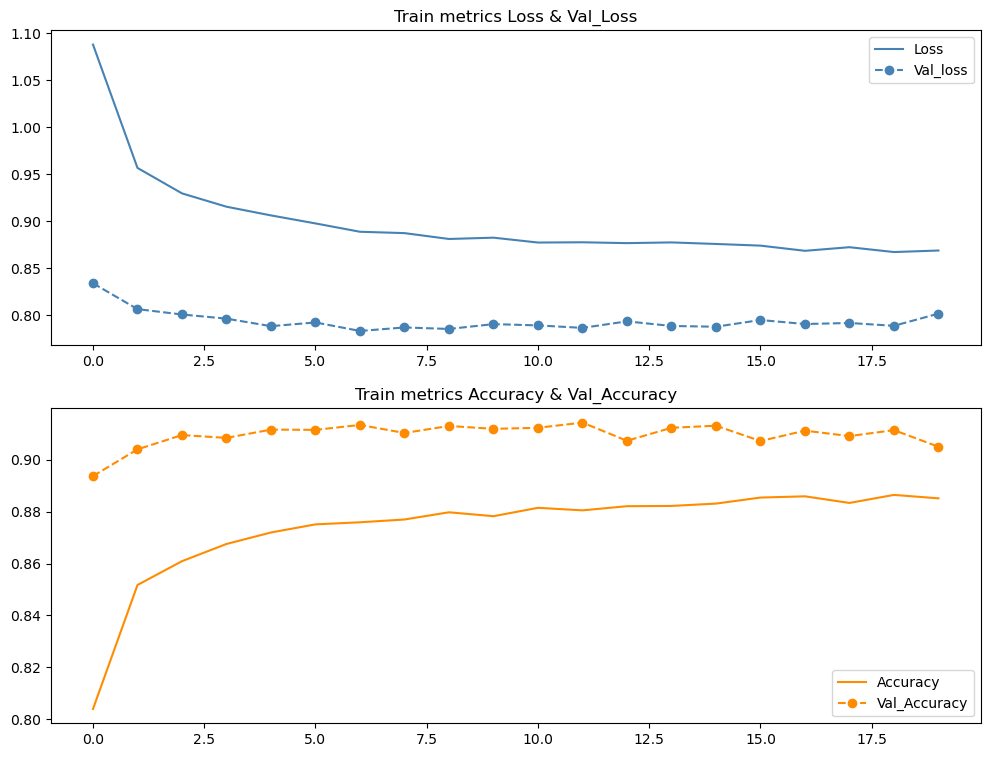

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

axes[0].set_title('Train metrics Loss & Val_Loss')
axes[0].plot(history.history['loss'], label='Loss', color='SteelBlue')
axes[0].plot(history.history['val_loss'], label='Val_loss', marker='o', linestyle='--', color='SteelBlue')
axes[0].legend()

axes[1].set_title('Train metrics Accuracy & Val_Accuracy')
axes[1].plot(history.history['probs_accuracy'], label='Accuracy', color='DarkOrange')
axes[1].plot(history.history['val_probs_accuracy'], label='Val_Accuracy', marker='o', linestyle='--', color='DarkOrange')
axes[1].legend()

plt.show()

Distance between the validation and the training curves is not big, so we have not overfitted to the data. And the training seems to have converged.

<a id='fine-tuning'></a>
## Fine-Tuning the Model

Now we will proceed to fine-tuning the layers of the base model to improve the classification performance.

In [15]:
base_model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=[keras.losses.CategoricalCrossentropy(from_logits=True), 
                    keras.losses.BinaryCrossentropy(from_logits=True)], 
              loss_weights=[1,0.7],
              metrics={'probs': 'accuracy', 'animals': 'accuracy'})

history = model.fit(x_train, [y_train_smoothed, y_train_animals], validation_split=0.2, epochs=14, verbose=1)

Epoch 1/14
1250/1250 [==============================] - 403s 314ms/step - loss: 0.7403 - probs_loss: 0.7144 - animals_loss: 0.0370 - probs_accuracy: 0.9307 - animals_accuracy: 0.9860 - val_loss: 0.6639 - val_probs_loss: 0.6501 - val_animals_loss: 0.0197 - val_probs_accuracy: 0.9539 - val_animals_accuracy: 0.9917
Epoch 2/14
1250/1250 [==============================] - 385s 307ms/step - loss: 0.6660 - probs_loss: 0.6515 - animals_loss: 0.0206 - probs_accuracy: 0.9529 - animals_accuracy: 0.9932 - val_loss: 0.6377 - val_probs_loss: 0.6257 - val_animals_loss: 0.0172 - val_probs_accuracy: 0.9598 - val_animals_accuracy: 0.9931
Epoch 3/14
1250/1250 [==============================] - 383s 306ms/step - loss: 0.6295 - probs_loss: 0.6189 - animals_loss: 0.0151 - probs_accuracy: 0.9635 - animals_accuracy: 0.9947 - val_loss: 0.6170 - val_probs_loss: 0.6066 - val_animals_loss: 0.0149 - val_probs_accuracy: 0.9665 - val_animals_accuracy: 0.9950
Epoch 4/14
1250/1250 [==============================] - 38

Let's see how well the fine-tuned model performs on the test set.

In [16]:
results = model.evaluate(x_test, [y_test_oh, y_test_animals])
classification_accuracy = results[3]
print(f'Model Loss: {round(results[0], 3)} \nModel Accuracy: {round(classification_accuracy, 3)}')

313/313 [==============================] - 23s 75ms/step - loss: 0.1829 - probs_loss: 0.1759 - animals_loss: 0.0101 - probs_accuracy: 0.9727 - animals_accuracy: 0.9976
Model Loss: 0.183 
Model Accuracy: 0.973


We can see that the classification accuracy on the test set has risen to 97%.

Next, we will visualize a confusion matrix to see if the model has any kind of patterns in its errors.

313/313 [==============================] - 28s 84ms/step


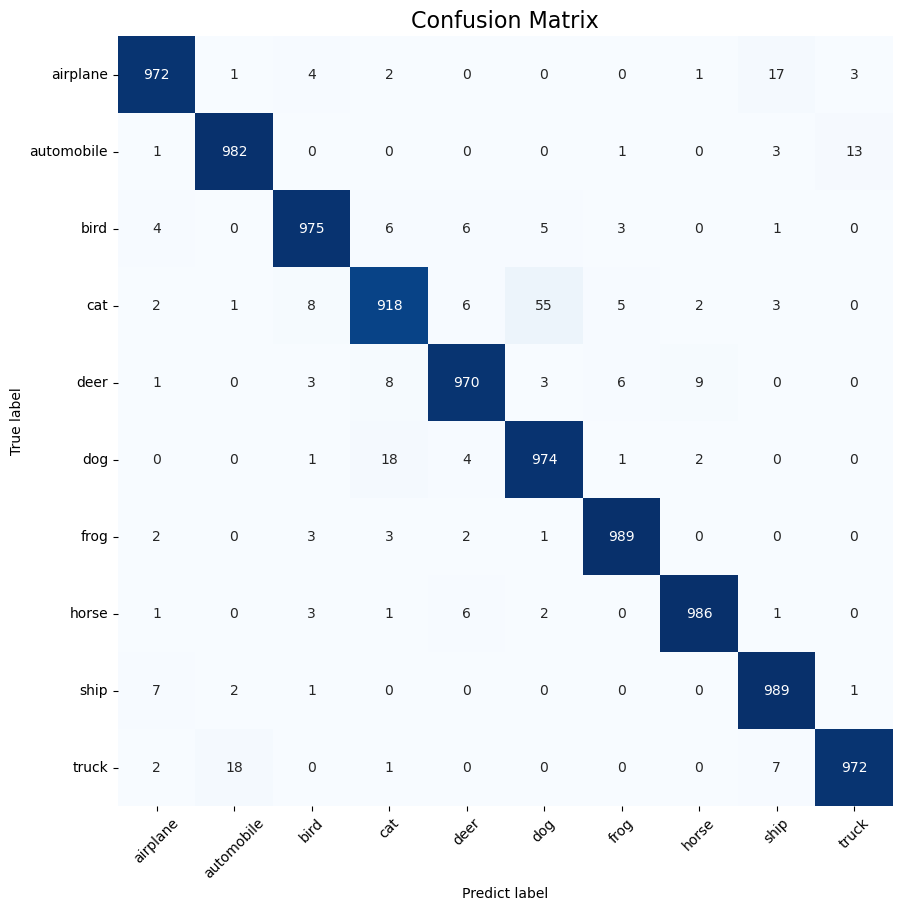

In [17]:
predictions = model.predict(x_test)

predicted_labels = [np.argmax(i) for i in predictions[0]]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, predicted_labels), annot=True, cbar=False, fmt='1d', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix', fontsize=16)
ax.set_xlabel('Predict label')
ax.set_ylabel('True label')
ax.set_xticklabels([lbl for lbl in class_labels], rotation=45)
ax.set_yticklabels(([lbl for lbl in class_labels]), rotation=0)
plt.show()

From the confusion matrix we can conclude that the model makes few mistakes when it comes to distinguishing between an animal and non-animal: 
- horses are confused with airplanes 8 times, and with ships 1 time; 
- frogs are confused with airplanes 3 times; 
- deers are also confused with airplanes 2 times, with ships 2 times, and with truck 1 time;
- cats are confused with airplanes 6 times, 2 times with automobiles, 4 times with ships, and 1 time with trucks;
- birds are confused with airplanes 9 times, and with ships 1 time;
- airplanes are confused with birds 2 times, cats - 1 time, and horses - 1 time;

The rest of the mistakes are within the animals/non-animals groups.

The hardest classes are dogs and cats, as they contribute a lot to the total error count and get messed up by the model. 

<a id='error-analysis'></a>
## Manual Error Analysis

We will proceed to identifying the mispredicted images and analysing possible factors that made the prediction hard for the neural network.

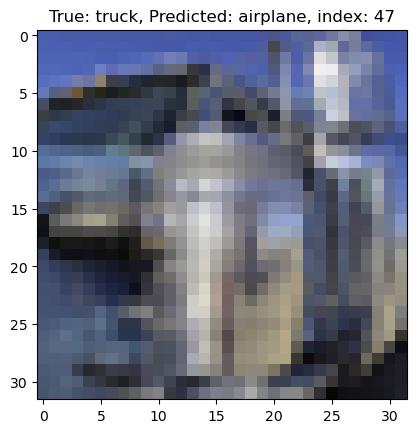

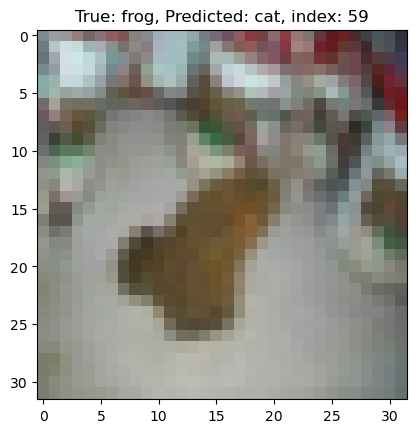

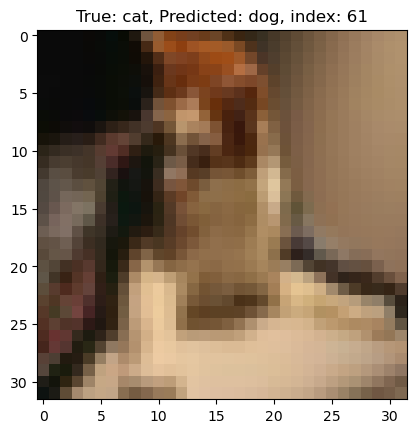

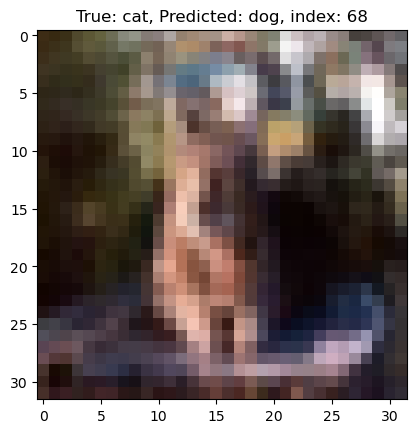

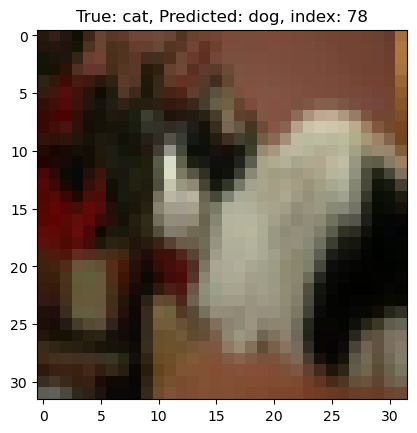

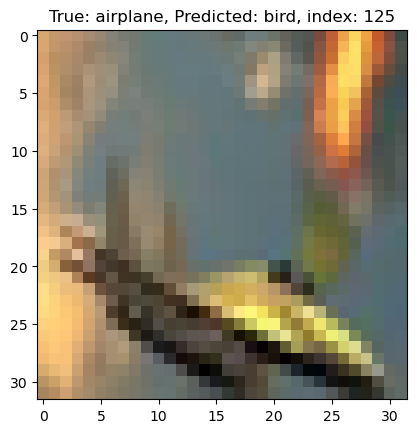

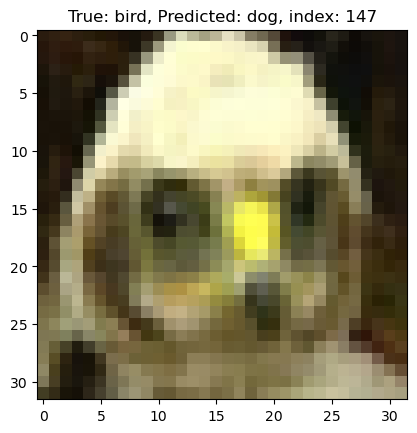

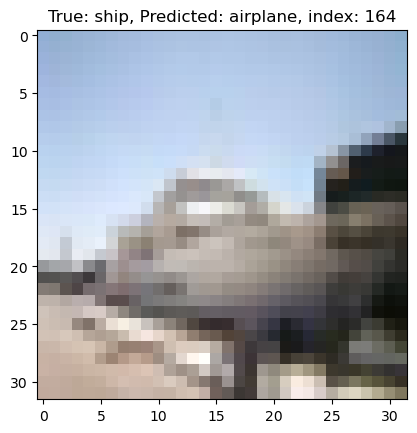

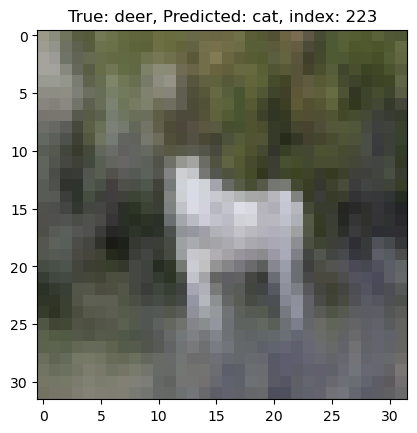

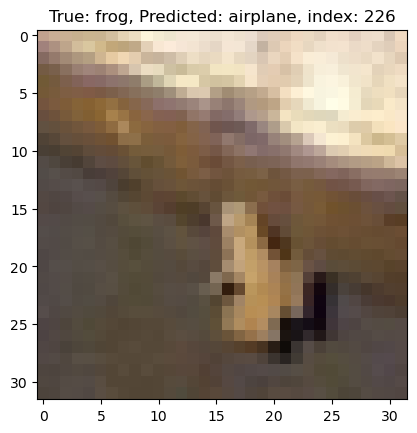

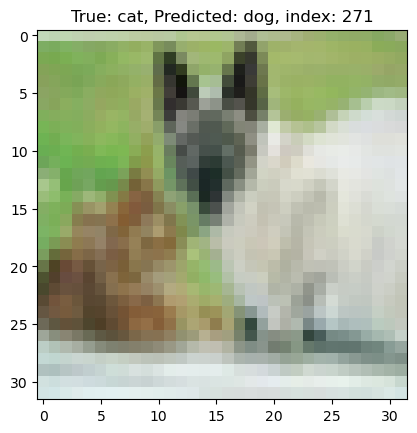

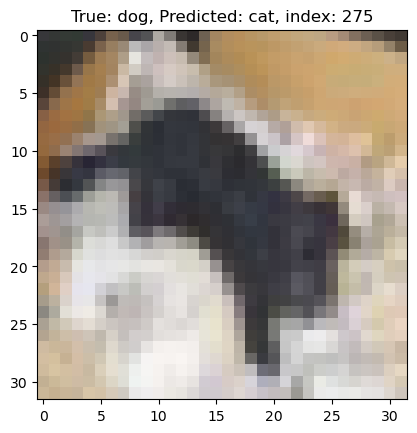

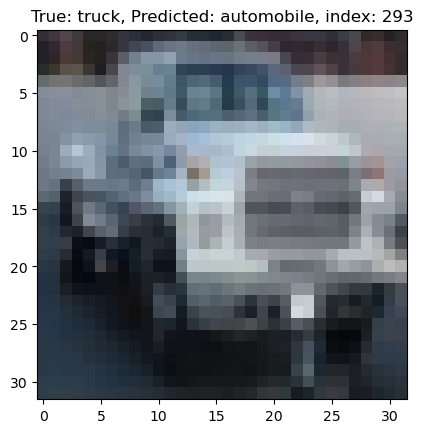

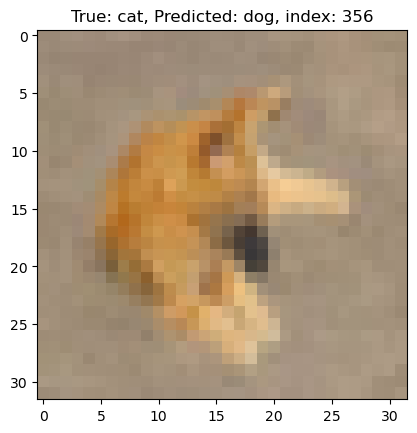

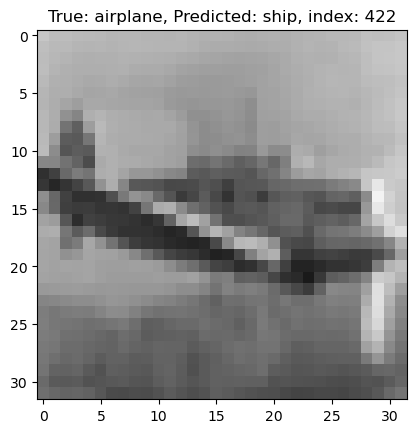

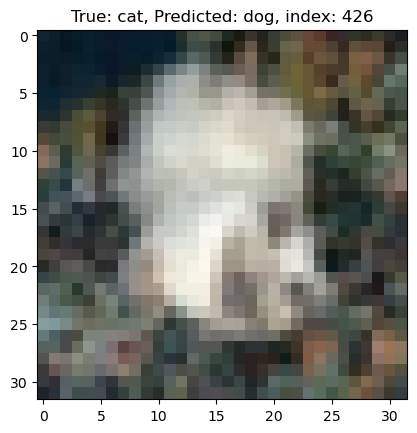

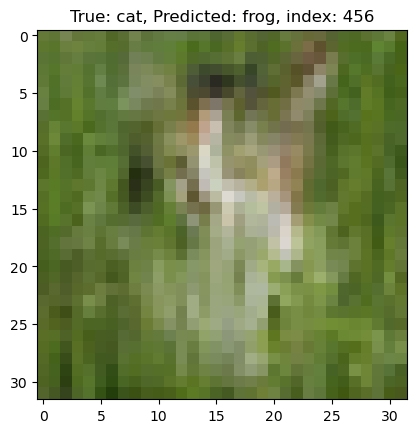

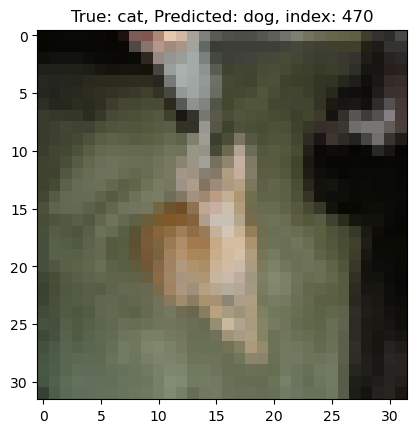

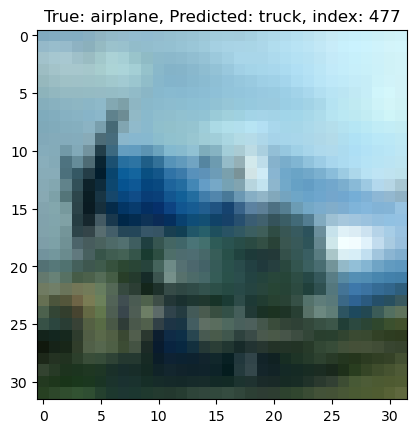

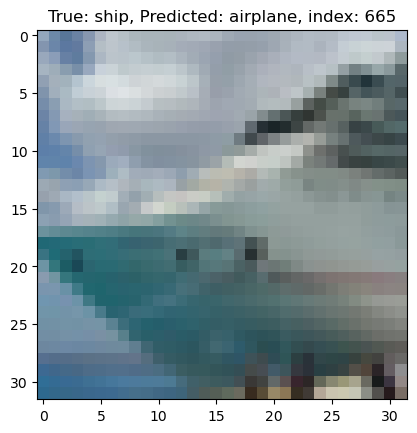

In [20]:
misclassified_indices = np.where(predicted_labels != np.squeeze(y_test))[0]

# Specify the mispredicted classes to render in case if we want only the specific ones.
mispredicted_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
filtered_indices = [idx for idx in misclassified_indices if np.squeeze(y_test)[idx] in mispredicted_classes]

# Show the first 20 images.
for idx in filtered_indices[:20]:
    plt.imshow(x_test[idx])
    true_label = np.squeeze(y_test)[idx]
    predicted_label = predicted_labels[idx]
    plt.title(f'True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}, index: {idx}')
    plt.show()

Having conducted manual error analysis, we have identified several repetitive patterns that contribute to erroneous predictions:

- cluttered and noisy backgrounds
- partially occluded objects
- abundance of green, leading to more frequent predictions of frogs
- for outdoor animals, the model predicts dogs more often than cats (and vice versa: indoor animals are more often classified as cats)
- unusual animal poses
- small dogs are mispredicted as cats
- large dogs are mispredicted as horses
- small ears lead to the prediction of a cat
- a blue background leads to predictions of planes
- distinct horizontal lines lead to predictions of ships
- spotted animals are mispredicted as frogs

<a id='conclusion'></a>
## Conclusion

To sum up, our approach to CIFAR-10 image classification, leveraging the EfficientNetV2B1 architecture, label smoothing, and multitask learning, has yielded promising results. Through manual error analysis, we identified recurring patterns that contribute to incorrect predictions. These patterns encompass challenges such as cluttered and noisy backgrounds, partially occluded objects, color influences, contextual cues (indoor vs. outdoor environments), unusual animal poses, and distinctive features such as small ears or specific background colors, leading to misclassifications.

By integrating EfficientNet's robust features, we harnessed its ability to handle complex image characteristics and extract meaningful representations, all while utilizing fewer resources without sacrificing accuracy. The application of label smoothing further bolstered the model's robustness by transforming class labels into multi-dimensional vectors, enabling the network to generalize more effectively. Moreover, our implementation of multitask learning facilitated simultaneous predictions of class labels and animal presence within the images, effectively leveraging shared knowledge and optimizing predictive accuracy.

This comprehensive approach has propelled our CIFAR-10 prediction model to achieve noticeable performance gains. As a foundation for future enhancements, we recommend exploring opportunities for fine-tuning the model's hyperparameters, integrating additional data augmentation techniques, or experimenting with alternative architectures.